In [1]:
import numpy as np
import math
from copy import deepcopy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from utils import *

# Rendezvous and Docking

In this example, we demonstrate the use of Linear Quadratic Regulator (LQR) control for spacecraft rendezvous and docking maneuvers. The goal is to bring a chaser spacecraft (SpaceX Dragon 1) to dock with a target spacecraft (International Space Station, ISS) in orbit using optimal control techniques.

## Problem Formulation

The dynamics of the Dragon vehicle can be modeled with [Clohessy-Wiltshire equations](https://en.wikipedia.org/wiki/Clohessy%E2%80%93Wiltshire_equations), which is a linear dynamics model in continuous time.


$$ \begin{align}
x &= [r_x, r_y, r_z, v_x, v_y, v_z]^T,\\
u &= [t_x, t_y, t_z]^T, \end{align}
$$

where $r$ is a relative position of the Dragon spacecraft with respect to the ISS, $v$ is the relative velocity, and $t$ is the thrust on the spacecraft. The continuous time dynamics of the vehicle are the following:

$$ \begin{align}
\dot{x} &= \begin{bmatrix}0  &   0 & 0  &  1 &  0 &  0 \\  
         0 &    0 & 0  &  0 &  1 &  0 \\ 
         0 &    0 & 0 &   0 &  0 &  1\\
         3n^2 &0 & 0  &  0 &  2n &0 \\
         0  &   0 & 0  & -2n &0  & 0\\
         0  &   0 &-n^2 & 0 &  0 &  0 \end{bmatrix} + \frac{1}{m} \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} u,
\end{align}
$$

where $n = \sqrt{\mu/a^3}$, with $\mu$ being the [standard gravitational parameter](https://en.wikipedia.org/wiki/Standard_gravitational_parameter), and $a$ being the semi-major axis of the orbit of the ISS. 

First, we need to discretize the continuous time dynamics using matrix exponential:

In [2]:
def create_dynamics(dt: float) -> np.ndarray:
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = math.sqrt(mu/a**3)    # mean motion
    
    # continuous-time state-space representation
    A_c = np.array([[0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1],
                    [3*n**2, 0, 0, 0, 2*n, 0],
                    [0, 0, 0, -2*n, 0, 0],
                    [0, 0, -n**2, 0, 0, 0]])
    B_c = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0],
                    [.1, 0, 0],
                    [0, .1, 0],
                    [0, 0, .1]])
    
    # convert to discrete-time
    nx = 6
    nu = 3
    H = np.block([[A_c, B_c], [np.zeros((nu, nx)), np.zeros((nu, nu))]])
    exp_H = expm(H * dt)
    
    A_d = exp_H[0:nx, 0:nx]
    B_d = exp_H[0:nx, nx:nx+nu]
    
    return A_d, B_d
    

We are going to use Linear Quadratic Regulator (LQR) to design an optimal controller for the system.

Given the reference trajectory`X_ref`, track it with finite-horizon LQR: 

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref, i})^TQ(x_i - x_{ref, i}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N- x_{ref, N})^TQ_f
(x_N- x_{ref, N})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$

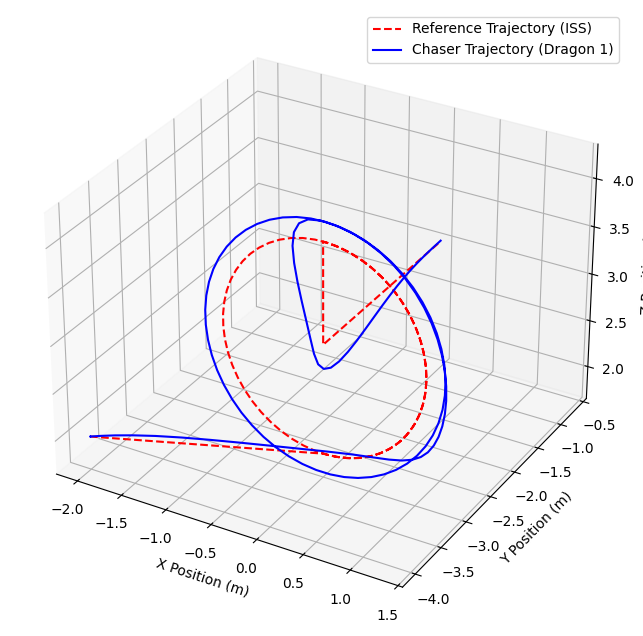

In [3]:
dt = 1.0
A, B = create_dynamics(dt)

nx, nu = B.shape

u_max = 0.4 * np.ones(nu)  # maximum control input
u_min = -1.0 * u_max        # minimum control input

N_main = 100
N_padding = 20
N = N_main + N_padding
t_vec = np.arange(N) * dt

X_ref = create_desired_trajectory(N, dt, N_padding)
x0 = X_ref[0]
xg = X_ref[-1]

# Q = np.eye(nx)
Q = np.diag([1.0, 1.0, 1.0, 0.1, 0.1, 0.1])  # state cost matrix
R = np.eye(nu) 
Qf = 10.0 * np.eye(nx)
K = [np.zeros((nu, nx)) for _ in range(N-1)]  # feedback gain matrices
P = deepcopy(Qf)  # cost-to-go matrix at final time step
# Backward pass to compute LQR gain matrices
for k in range(N-2, -1, -1):
    S = R + B.T @ P @ B
    K[k] = np.linalg.solve(S, B.T @ P @ A)  # K = S^{-1} B^T P A
    P = Q + A.T @ P @ (A - B @ K[k])
    
# Simulation
X_sim = [np.zeros(nx) for _ in range(N)]
U_sim = [np.zeros(nu) for _ in range(N-1)]
X_sim[0] = x0
for k in range(N-1):
    # LQR control law with reference tracking
    u = -K[k] @ (X_sim[k] - X_ref[k])
    # Apply control input constraints
    u = np.minimum(np.maximum(u, u_min), u_max)
    U_sim[k] = u
    # System dynamics update
    X_sim[k+1] = A @ X_sim[k] + B @ u
    
X_sim = np.array(X_sim)
U_sim = np.array(U_sim)
    
# plot the results in jupyter notebook
# plot the 3D trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_ref[:, 0], X_ref[:, 1], X_ref[:, 2], 'r--', label='Reference Trajectory (ISS)')
ax.plot(X_sim[:, 0], X_sim[:, 1], X_sim[:, 2], 'b-', label='Chaser Trajectory (Dragon 1)')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.legend()
plt.show()

In [5]:
vis = animate_rendezvous(X_sim, X_ref, dt, show_reference=True)

html_path = "output/rendezvous_animation.html"
with open(html_path, "w") as f:
    f.write(vis.static_html())

print(f"Animation saved to {html_path}")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Animation saved to output/rendezvous_animation.html
